In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score,recall_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics
from collections import defaultdict
from itertools import product
from collections import Counter
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# ################################################
# Data set 2: seizure data set

data = pd.read_csv('seizure_dataset.csv')
X = data.iloc[:,:178]
y = data.iloc[:,178]
features = list(X.columns.values)

# scaler = MinMaxScaler(feature_range=[0,100])
# scaler.fit(X)
# X_norm = pd.DataFrame(scaler.transform(X))
norm = MinMaxScaler().fit(X) 
X_norm = pd.DataFrame(norm.transform(X))
#X_norm = X


In [3]:
def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

In [4]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

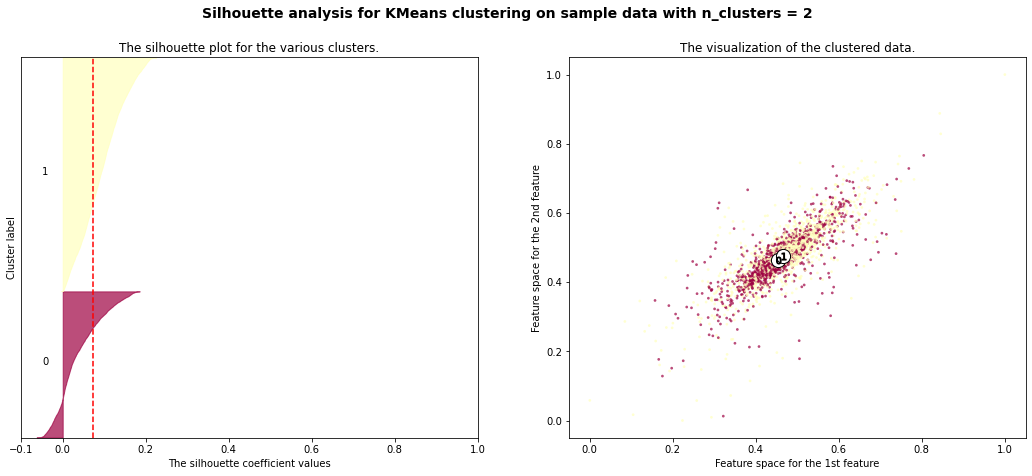

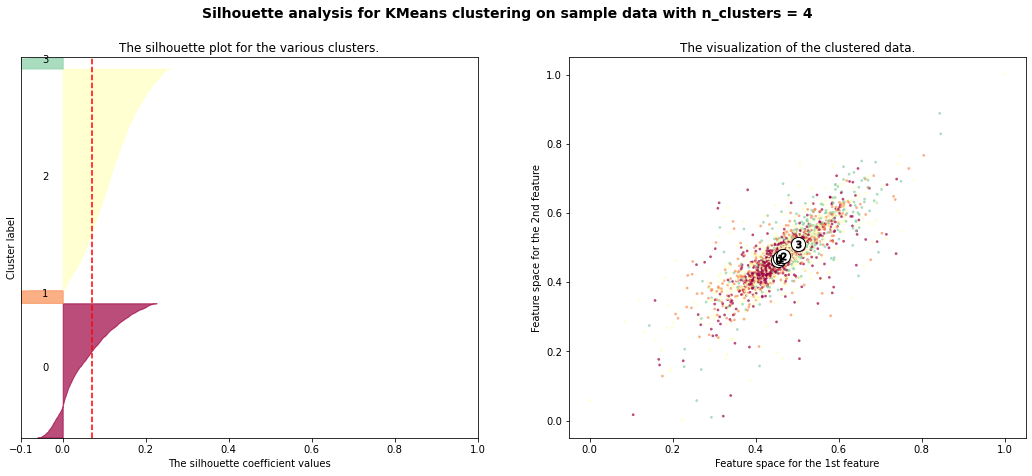

*****************************************************
        NMI  Average Silhouette Score  Accurracy
0  0.002900                  0.072104   0.223304
1  0.086611                  0.070358   0.279130


In [5]:
#################################################
# K means clustering
NMI = []
sils = []
acc = []

range_n_clusters = [2, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.labels_

##################################
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
##################################    
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float)  / n_clusters)
    ax2.scatter(X_norm.iloc[:, 10], X_norm.iloc[:, 8], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 10], centers[:, 8], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[10], c[8], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
    
print("*****************************************************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)


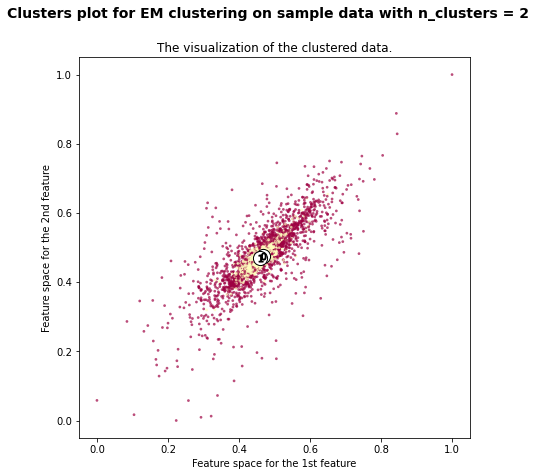

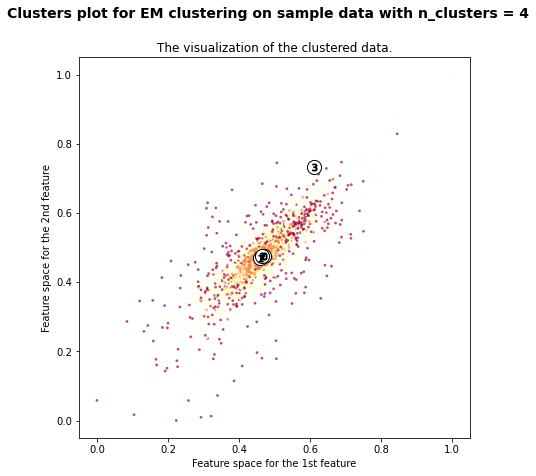

*****************************************************
        NMI  Average Silhouette Score  Accurracy
0  0.256687                  0.532683   0.356783
1  0.283509                  0.417825   0.378000


In [6]:
#################################################
# Expectation Maximization clustering
NMI = []
sils = []
acc = []
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_norm)
    cluster_labels = clusterer.predict(X_norm)

##################################
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
################################## 

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    plt.scatter(X_norm.iloc[:, 10], X_norm.iloc[:, 8], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.means_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 10], centers[:, 8], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter(c[10], c[8], marker='$%d$' % i, alpha=1,
                   s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Clusters plot for EM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
print("*****************************************************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)


explained variance ratio (first two components): [5.88887912e-02 5.53343548e-02 5.10548436e-02 4.98479903e-02
 4.46732075e-02 4.14921634e-02 4.03084753e-02 3.71360548e-02
 3.53252752e-02 3.47792389e-02 3.29667531e-02 3.18182964e-02
 2.98699526e-02 2.93558186e-02 2.61382607e-02 2.39543963e-02
 2.20414782e-02 2.06636803e-02 2.04857145e-02 1.98137391e-02
 1.97234462e-02 1.81454982e-02 1.74274094e-02 1.66400352e-02
 1.57516953e-02 1.54732569e-02 1.50296228e-02 1.43867909e-02
 1.35337961e-02 1.31592943e-02 1.27683564e-02 1.24095453e-02
 1.22900047e-02 1.10958549e-02 1.02768539e-02 9.48642089e-03
 7.65990545e-03 6.59310276e-03 6.07867298e-03 5.54650797e-03
 4.63860596e-03 4.20679838e-03 3.71713783e-03 3.07041782e-03
 2.59932019e-03 2.24035235e-03 2.11450197e-03 1.78502454e-03
 1.72783448e-03 1.46934615e-03 1.14280855e-03 1.10880527e-03
 9.34546338e-04 8.75588061e-04 8.11802092e-04 7.40006210e-04
 7.09501638e-04 5.89129266e-04 5.25556914e-04 4.98101194e-04
 4.57399278e-04 4.26281238e-04 3.565

Text(0.5, 1.0, 'PCA of seizure dataset')

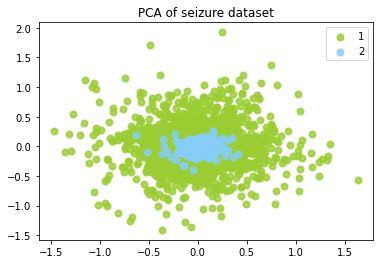

In [7]:
#################################################
#PCA feature transformation

pca = PCA(random_state=10)
X_r = pca.fit(X_norm).transform(X_norm)
X_pca = X_r
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
color =  ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
lw = 2


for color, i in zip(color, [1,2]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of seizure dataset')


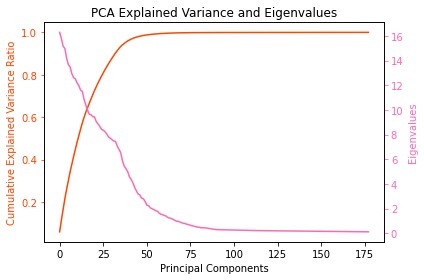

In [8]:
cum_var = np.cumsum(pca.explained_variance_ratio_)

fig, ax1 = plt.subplots()
ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'orangered')
ax1.set_xlabel('Principal Components')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cumulative Explained Variance Ratio', color='orangered')
ax1.tick_params('y', colors='orangered')
plt.grid(False)

ax2 = ax1.twinx()
ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'hotpink')
ax2.set_ylabel('Eigenvalues', color='hotpink')
ax2.tick_params('y', colors='hotpink')
plt.grid(False)

plt.title("PCA Explained Variance and Eigenvalues")
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Kernel PCA of seizure dataset')

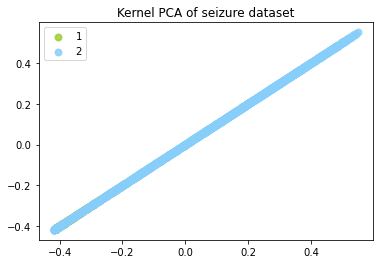

In [76]:
from sklearn.decomposition import KernelPCA
#################################################
#PCA feature transformation

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_r = kpca.fit(X_norm).transform(X_norm)
X_kpca = X_r

plt.figure()
color =  ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
lw = 2


for color, i in zip(color, [1,2]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 0],
                color=color, alpha=0.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Kernel PCA of seizure dataset')


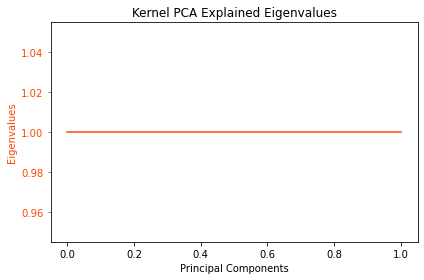

In [40]:

fig, ax1 = plt.subplots()
ax1.plot(list(range(len(kpca.lambdas_))), kpca.lambdas_, 'orangered')
ax1.set_xlabel('Principal Components')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Eigenvalues', color='orangered')
ax1.tick_params('y', colors='orangered')
plt.grid(False)

plt.title("Kernel PCA Explained Eigenvalues")
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'ICA of seizure dataset')

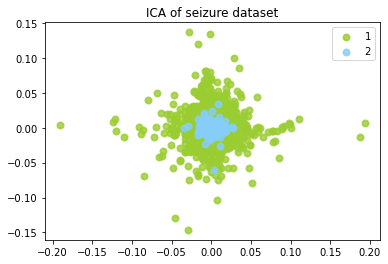

In [22]:

#################################################
#ICA feature transformation

ica = FastICA( random_state=10)
X_r = ica.fit(X_norm).transform(X_norm)
X_ica = X_r

plt.figure()
color = ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
lw = 2

for color, i in zip(color, [1,2]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('ICA of seizure dataset')


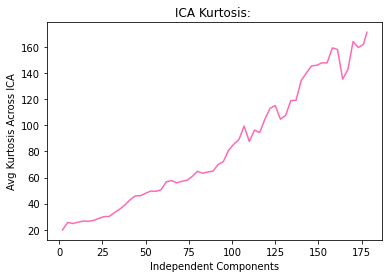

In [12]:
dims = list(np.arange(2,(X.shape[1]-1),3))
dims.append(X.shape[1])
ica = FastICA(random_state=10)
kurt = []

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_norm)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())

plt.figure()
plt.title("ICA Kurtosis: ")
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across ICA")
plt.plot(dims, kurt, 'hotpink')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'Random Projection of seizure dataset')

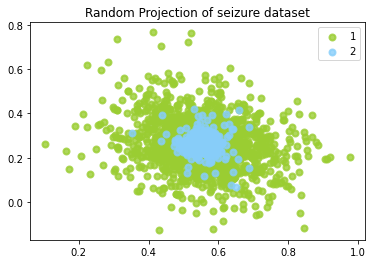

In [52]:

#################################################
#Random Projection feature transformation

rca = GaussianRandomProjection(n_components=178, random_state=10)
X_r = rca.fit_transform(X_norm)
X_rca = X_r

plt.figure()
color = ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
lw = 2

for color, i in zip(color, [1,2]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Random Projection of seizure dataset')

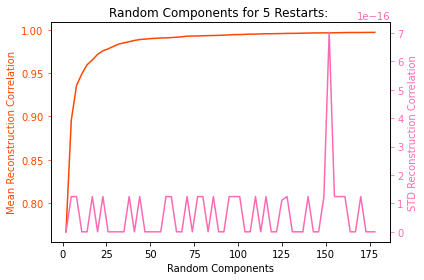

In [14]:
dims = list(np.arange(2,(X.shape[1]-1),3))
dims.append(X.shape[1])
tmp = defaultdict(dict)

for i,dim in product(range(5),dims):   
    rp = GaussianRandomProjection(n_components=dim, random_state=100)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X_norm), X_norm)
    
tmp = pd.DataFrame(tmp).T
mean_recon = tmp.mean(axis=1).tolist()
std_recon = tmp.std(axis=1).tolist()


fig, ax1 = plt.subplots()
ax1.plot(dims,mean_recon, 'orangered')
ax1.set_xlabel('Random Components')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mean Reconstruction Correlation', color='orangered')
ax1.tick_params('y', colors='orangered')
plt.grid(False)

ax2 = ax1.twinx()
ax2.plot(dims,std_recon, 'hotpink')
ax2.set_ylabel('STD Reconstruction Correlation', color='hotpink')
ax2.tick_params('y', colors='hotpink')
plt.grid(False)

plt.title("Random Components for 5 Restarts: ")
fig.tight_layout()
plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import preprocessing
df_original = data
rfc = RFC(n_estimators=200,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
imp = rfc.fit(X_norm,y).feature_importances_ 
imp = pd.DataFrame(imp,columns=['Feature Importance'],index=X.columns)
imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
imp['Cum Sum'] = imp['Feature Importance'].cumsum()
imp = imp[imp['Cum Sum']<=0.95]
top_cols = imp.index.tolist()

1
2


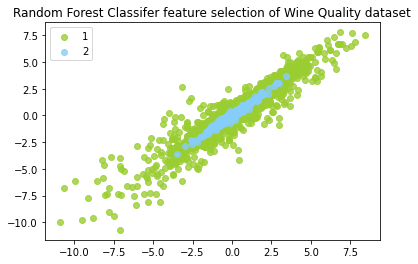

In [51]:
X_r= X[top_cols]
X_r = preprocessing.scale(X_r)
#X_r = np.array(X_r.values,dtype='int64')
X_rfc = X_r
plt.figure()
color = ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
lw = 2
for color, i in zip(color, [1,2]):
    print(i)
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Random Forest Classifer feature selection of Wine Quality dataset')
plt.show()

In [23]:
range_n_clusters = [2, 4]
NMI = []
sils = []
acc = []

X_pca = PCA(n_components=40,random_state=5).fit(X_norm).transform(X_norm)
X_test = pd.DataFrame(X_pca)
print("PCA")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)

print("******************K-means**********************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)

NMI = []
sils = []
acc = []
print("******************EM**********************")
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.predict(X_test)
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)

#---------------#---------------#---------------#---------------#---------------#---------------#---------------
#---------------#---------------#---------------#---------------#---------------#---------------#---------------

NMI = []
sils = []
acc = []
X_ica = FastICA(n_components=178,random_state=5).fit(X_norm).transform(X_norm)
X_test = pd.DataFrame(X_ica)
print("ICA")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
    
print("******************K-means**********************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)

NMI = []
sils = []
acc = []
print("******************EM**********************")
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.predict(X_test)
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)



#---------------#---------------#---------------#---------------#---------------#---------------#---------------
#---------------#---------------#---------------#---------------#---------------#---------------#---------------



NMI = []
sils = []
acc = []


X_rca = GaussianRandomProjection(n_components=35, random_state=10).fit_transform(X_norm)
X_test = pd.DataFrame(X_rca)
print("RP")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)

print("******************K-means**********************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)

NMI = []
sils = []
acc = []
print("******************EM**********************")
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.predict(X_test)
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)



#---------------#---------------#---------------#---------------#---------------#---------------#---------------
#---------------#---------------#---------------#---------------#---------------#---------------#---------------

    
NMI = []
sils = []
acc = []
X_test = X_rfc
print("RFC")
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X_norm, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)

print("******************K-means**********************")
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)

NMI = []
sils = []
acc = []
print("******************EM**********************")
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.predict(X_test)
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    y_mode_vote = cluster_predictions(y,cluster_labels)
    accuacy_score = metrics.accuracy_score(y,y_mode_vote)
    NMI.append(normalized_mutual_info_score(y, cluster_labels))
    sils.append(silhouette_avg)
    acc.append(accuacy_score)
output = {'NMI': NMI, 
        'Average Silhouette Score': sils, 
        'Accurracy': acc} 
output = pd.DataFrame(output, columns= ['NMI', 'Average Silhouette Score','Accurracy'])
print(output)


PCA
******************K-means**********************
        NMI  Average Silhouette Score  Accurracy
0  0.075968                  0.605075   0.241739
1  0.084154                  0.064463   0.278174
******************EM**********************
        NMI  Average Silhouette Score  Accurracy
0  0.355607                  0.487348   0.392435
1  0.412040                 -0.085085   0.505217
ICA
******************K-means**********************
        NMI  Average Silhouette Score  Accurracy
0  0.053644                  0.621253   0.233913
1  0.015069                  0.034775   0.222522
******************EM**********************
        NMI  Average Silhouette Score  Accurracy
0  0.194444                  0.434230   0.351043
1  0.195841                  0.415968   0.353826
RP
******************K-means**********************
        NMI  Average Silhouette Score  Accurracy
0  0.081090                  0.590329   0.247739
1  0.172651                  0.611338   0.300435
******************EM****

For n_clusters = 2 The average silhouette_score is : 0.6050752859498605
The NMI score is: 0.075968


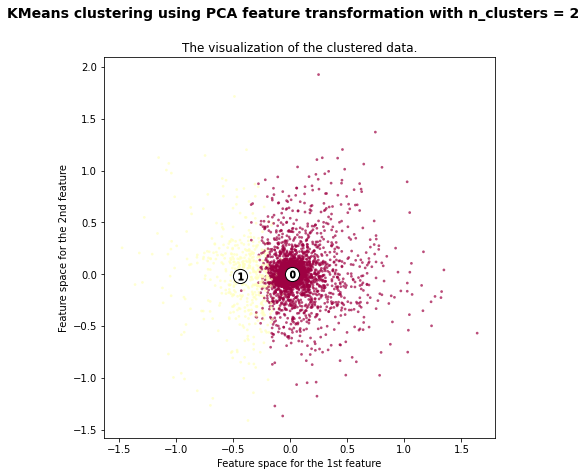

NMI score: 0.355607


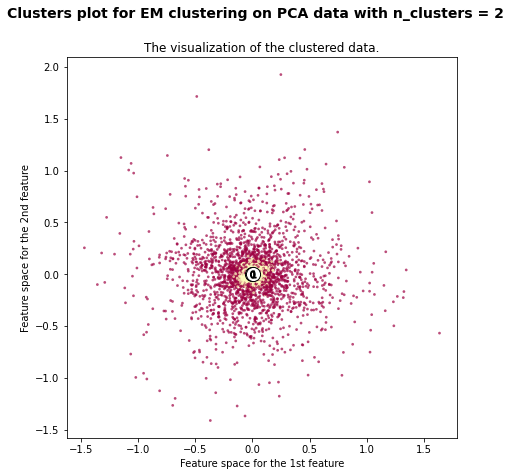

In [34]:
#################################################
#Rerun clustering on transformed features
range_n_clusters = [2]
X_test=pd.DataFrame(X_pca)
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)

    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.labels_

    silhouette_avg = silhouette_score(X_test, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    print("The NMI score is: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax.scatter( X_test.iloc[:, 0], X_test.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("KMeans clustering using PCA feature transformation "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

X_test=pd.DataFrame(X_pca)
for n_clusters in range_n_clusters:
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    ax = fig.add_subplot(111)

    clusterer = GaussianMixture(n_components=n_clusters, random_state=10).fit(X_test)
    cluster_labels = clusterer.predict(X_test)
    print("NMI score: %.6f" % normalized_mutual_info_score(y, cluster_labels))

    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    plt.scatter( X_test.iloc[:, 0], X_test.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.means_

    plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter( c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Clusters plot for EM clustering on PCA data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

    plt.show()

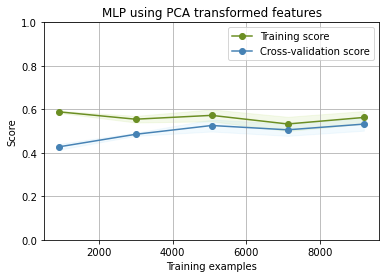

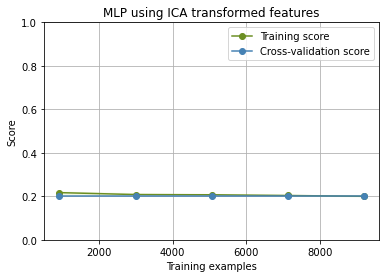

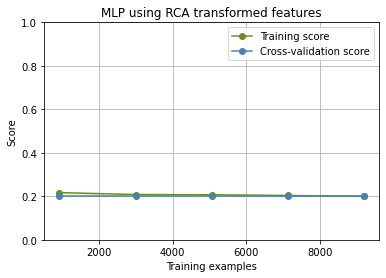

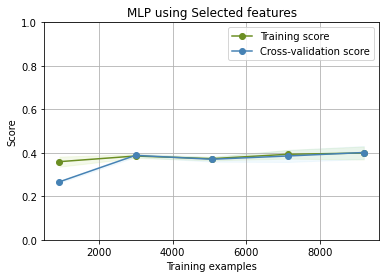

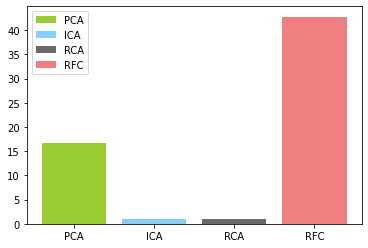

In [37]:

#################################################
# Rerun ANN on transformed features
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

color = ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='yellowgreen')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="lightskyblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="olivedrab",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="steelblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    
#'olivedrab', 'steelblue']

running_time=[]
clf = MLPClassifier(hidden_layer_sizes=(20, 5), random_state=0, solver="lbfgs")
start=time.time()
plot_learning_curve(clf, "MLP using PCA transformed features", X_pca, y, ylim=[0,1])
running_time.append(time.time()-start)
start=time.time()
plot_learning_curve(clf, "MLP using ICA transformed features", X_ica, y, ylim=[0,1])
running_time.append(time.time()-start)
start=time.time()
plot_learning_curve(clf, "MLP using RCA transformed features", X_rca, y, ylim=[0,1])
running_time.append(time.time()-start)
start=time.time()
plot_learning_curve(clf, "MLP using Selected features", X_rfc, y, ylim=[0,1])
running_time.append(time.time()-start)

transform_features=['PCA', 'ICA', 'RCA', 'RFC']
# Make the plot
for i in range(len(transform_features)):
    plt.bar(transform_features[i], running_time[i], color=color[i], label=transform_features[i])
plt.xticks(transform_features, ('PCA', 'ICA', 'RCA', 'RFC'))
# Create legend & Show graphic
plt.legend()
plt.show()

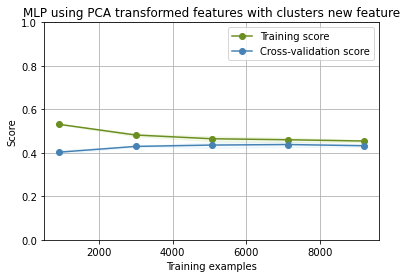

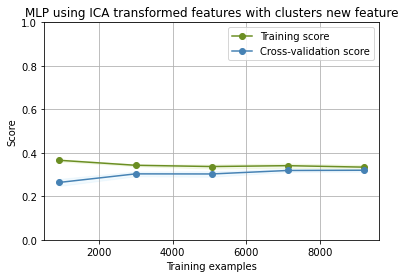

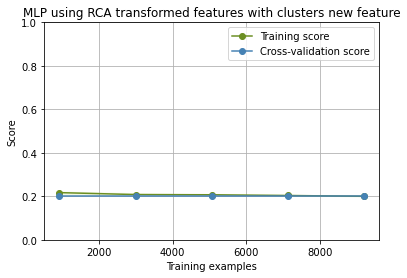

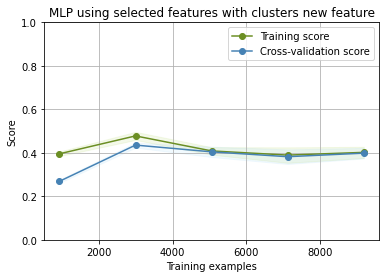

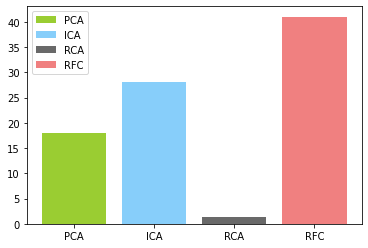

In [38]:
#################################################
# Rerun ANN on transformed features with clusters new feature
running_time=[]
clf = MLPClassifier(hidden_layer_sizes=(20, 5), random_state=0, solver="lbfgs")

start=time.time()
clusterer = KMeans(n_clusters=2, random_state=10).fit(X_pca)
y_kmeans = clusterer.labels_
X_df = pd.DataFrame(X_pca)
X_df[178] = y_kmeans
plot_learning_curve(clf, "MLP using PCA transformed features with clusters new feature", X_df, y, ylim=[0, 1])
running_time.append(time.time()-start)

start=time.time()
clusterer = KMeans(n_clusters=2, random_state=10).fit(X_ica)
y_kmeans = clusterer.labels_
X_df = pd.DataFrame(X_ica)
X_df[178] = y_kmeans
plot_learning_curve(clf, "MLP using ICA transformed features with clusters new feature", X_df, y, ylim=[0, 1])
running_time.append(time.time()-start)

start=time.time()
clusterer = KMeans(n_clusters=2, random_state=10).fit(X_rca)
y_kmeans = clusterer.labels_
X_df = pd.DataFrame(X_rca)
X_df[178] = y_kmeans
plot_learning_curve(clf, "MLP using RCA transformed features with clusters new feature", X_df, y, ylim=[0, 1])
running_time.append(time.time()-start)

start=time.time()
clusterer = KMeans(n_clusters=2, random_state=10).fit(X_rfc)
y_kmeans = clusterer.labels_
X_df = pd.DataFrame(X_rfc)
X_df[178] = y_kmeans
plot_learning_curve(clf, "MLP using selected features with clusters new feature", X_df, y, ylim=[0, 1])
running_time.append(time.time()-start)

color = ['yellowgreen', 'lightskyblue','dimgray','lightcoral','yellow']
transform_features=['PCA', 'ICA', 'RCA', 'RFC']
# Make the plot
for i in range(len(transform_features)):
    plt.bar(transform_features[i], running_time[i], color=color[i], label=transform_features[i])
plt.xticks(transform_features, ('PCA', 'ICA', 'RCA', 'RFC'))
# Create legend & Show graphic
plt.legend()
plt.show()